## **1. Loading Dataset**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [27]:
# train_data = pd.read_csv('data/train.csv')
# test_data = pd.read_csv('data/test.csv')

train_data = pd.read_pickle("data/train.pkl")
test_data = pd.read_pickle("data/test.pkl")

In [28]:
X_train = np.vstack(train_data['data'].values)
y_train = train_data['labels'].values

X_test = np.vstack(test_data['data'].values)
y_test = test_data['labels'].values

In [29]:
X_train = X_train / 255.0
X_test = X_test  / 255.0

In [31]:
# Adding bias term to X
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

In [32]:
#One Hot Encoding Target Class
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

## **2. Logistic Regression Model**

In [76]:
class logistic_regression:
    def __init__(self, learning_rate=0.01, epochs=10):
    
        self.learning_rate = learning_rate
        self.epochs = epochs

        #Weight Initalization
        self.num_features = None
        self.num_classes = None
        self.weights = None

        # Initialize lists for tracking losses
        self.train_losses = []
        self.test_losses = []

    # Logistic Regression Functions
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict(self, X):
        y_pred = self.softmax(np.dot(X, self.weights))
        return np.argmax(y_pred, axis=1)
    
    def log_loss(self, y, y_pred, epsilon=1e-15):
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    
    def categorical_crossentropy(self, y, y_pred, epsilon=1e-15):
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def gradient_descent(self, X, y, weights, lr):
        y_pred = self.softmax(np.dot(X, weights))
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)
        return weights - lr * gradient


    def fit(self, X_train, y_train, X_test=None, y_test=None):
        self.num_features = X_train.shape[1]
        self.num_classes = y_train.shape[1]
        self.weights = np.random.randn(self.num_features, self.num_classes)
    
        for epoch in range(self.epochs):
            # Update Weights
            self.weights = self.gradient_descent(X_train, y_train, self.weights, self.learning_rate)

            train_pred = self.softmax(np.dot(X_train, self.weights))
            train_loss = self.categorical_crossentropy(y_train, train_pred)
            self.train_losses.append(train_loss)

            if X_test is not None and y_test is not None:
                test_pred = self.softmax(np.dot(X_test, self.weights))
                test_loss = self.categorical_crossentropy(y_test, test_pred)
                self.test_losses.append(test_loss)
            else:
                test_loss = None

            # if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{self.epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")


In [78]:
lr = logistic_regression(learning_rate=0.01, epochs=10)

In [79]:
lr.fit(X_train, y_train, X_test, y_test)

Epoch 1/10: Train Loss = 26.2926, Test Loss = 26.2529
Epoch 2/10: Train Loss = 25.2833, Test Loss = 25.2147
Epoch 3/10: Train Loss = 24.3783, Test Loss = 24.2875
Epoch 4/10: Train Loss = 23.6030, Test Loss = 23.5043
Epoch 5/10: Train Loss = 22.9535, Test Loss = 22.8453
Epoch 6/10: Train Loss = 22.4114, Test Loss = 22.3030
Epoch 7/10: Train Loss = 21.9566, Test Loss = 21.8529
Epoch 8/10: Train Loss = 21.5715, Test Loss = 21.4738
Epoch 9/10: Train Loss = 21.2451, Test Loss = 21.1515
Epoch 10/10: Train Loss = 20.9659, Test Loss = 20.8718


## **3. Model Evaluation**

In [92]:
def confusion_matrix(y_true, y_pred):
    
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    y_true_indices = np.argmax(y_true, axis=1)
    
    for t, p in zip(y_true_indices, y_pred):
        cm[t, p] += 1
    
    return cm

def accuracy(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)  #Converting one-hot encoded back to label encoded
    return np.sum(y_true_label == y_pred) / len(y_true_label)


def precision(cm):
    
    precisions = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        if tp + fp > 0:
            precisions.append(tp / (tp + fp))
        else:
            precisions.append(0)
    return np.mean(precisions)

def recall(cm):
    
    recalls = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        if tp + fn > 0:
            recalls.append(tp / (tp + fn))
        else:
            recalls.append(0)
    return np.mean(recalls)

def f1_score(cm):
    
    precisions = precision(cm)
    recalls = recall(cm)
    
    if (precisions + recalls) > 0:
        return 2 * (precisions * recalls) / (precisions + recalls) 
    else:
        return 0

In [96]:
# Generate predictions for train and test sets
train_pred = lr.predict(X_train)


# Calculate training metrics
train_cm = confusion_matrix(y_train, train_pred)
train_accuracy = accuracy(y_train, train_pred)
train_precision = precision(train_cm)
train_recall = recall(train_cm)
train_f1 = f1_score(train_cm)

# Print Metrics
print("\nTraining Metrics:")
print("Confusion Matrix:\n", train_cm)
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


test_pred = lr.predict(X_test)

test_cm = confusion_matrix(y_test, test_pred)
test_accuracy = accuracy(y_test, test_pred)
test_precision = precision(test_cm)
test_recall = recall(test_cm)
test_f1 = f1_score(test_cm)

print("\nValidation Metrics:")
print("Confusion Matrix:\n", test_cm)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")



Training Metrics:
Confusion Matrix:
 [[  18  166  697 2172  769 1057    0  115    0    6]
 [  23  331  715 1298  884 1404    0  333    0   12]
 [  23  423  918 1213 1460  700    1  252    0   10]
 [  57  389  898 1069 1508  709    2  330    0   38]
 [  13  418 1215  721 1689  635    0  295    0   14]
 [  68  355  961  835 1561  820    0  382    0   18]
 [  15  556  990  859 1540  713    0  309    0   18]
 [  21  422  834 1448 1258  640    0  371    0    6]
 [  41  140  697 1671  568 1744    0  115    0   24]
 [  46  322  569 1710  912 1158    0  282    0    1]]
Accuracy: 0.1043
Precision: 0.0704
Recall: 0.1043
F1 Score: 0.0841

Validation Metrics:
Confusion Matrix:
 [[  3  34 126 444 158 206   0  27   0   2]
 [  8  75 126 244 185 285   0  71   0   6]
 [  3  76 184 233 301 152   0  48   0   3]
 [ 11  80 183 220 287 146   0  66   0   7]
 [  1  83 250 153 338 125   0  49   0   1]
 [ 13  62 195 171 324 159   0  73   0   3]
 [  2  99 188 172 326 142   0  63   0   8]
 [ 10  85 182 264 232 1

# **4. Loss History**

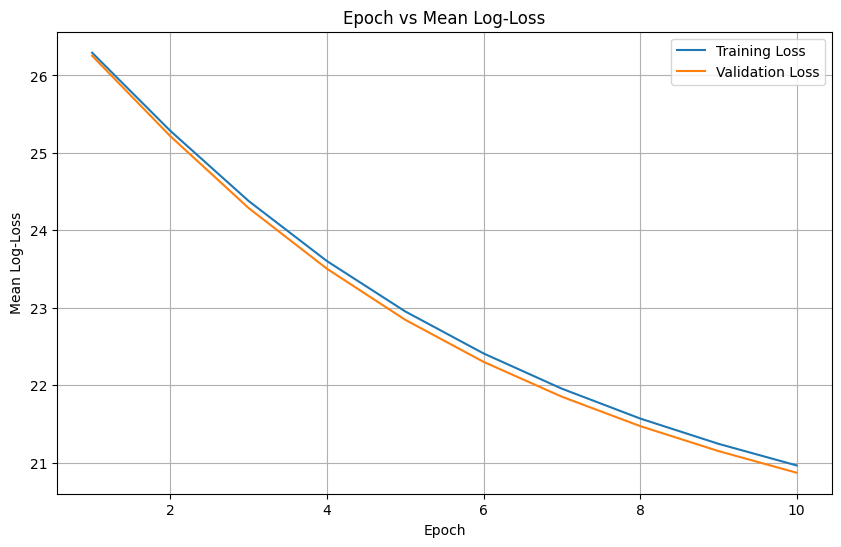

In [94]:
# Plot epoch vs log-loss
epochs = list(range(1, len(lr.train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr.train_losses, label='Training Loss')
plt.plot(epochs, lr.test_losses, label='Validation Loss')

plt.title('Epoch vs Mean Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Log-Loss')
plt.grid(True)
plt.legend()
plt.show()
